In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

import joblib
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from src.clustering import (
    plot_gmm_clusters,
    plot_gmm_log_likelihood_contours,
    preproc_features,
)
from src.database import get_dic_analysis_ids, get_dic_data, get_image
from src.roi import PolygonROISelector, filter_dataframe
from src.visualization import plot_dic_vectors

%matplotlib widget

load_dotenv()

DB_HOST = os.environ.get("DB_HOST", "150.145.51.193")
DB_PORT = os.environ.get("DB_PORT", "5432")
DB_NAME = os.environ.get("DB_NAME", "planpincieux")
DB_USER = os.environ.get("DB_USER", "")
DB_PASSWORD = os.environ.get("DB_PASSWORD", "")

APP_HOST = os.environ.get("APP_HOST", "150.145.51.193")
APP_PORT = os.environ.get("APP_PORT", "8001")
GET_IMAGE_VIEW = os.environ.get("GET_IMAGE_VIEW", "images")

target_date = "2024-09-02"
camera_name = "PPCX_Tele"

min_velocity = 1  # Minimum velocity threshold in pixels, use -1 to disable
filter_outliers = True  # Whether to filter out low velocity vectors
tails_percentile = 0.001  # Percentile for tail filtering

output_dir = f"output/{camera_name}"

# Create the connection to the database
db_engine = create_engine(
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

In [2]:
# Build the output folder and base_name
base_name = f"{camera_name}_{target_date}_GMM"
output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

# Get DIC analysis metadata (filtered by date/camera)
dic_analyses = get_dic_analysis_ids(
    db_engine, reference_date=target_date, camera_name=camera_name
)
dic_analyses

dic_id camera_name          master_timestamp           slave_timestamp  \
0     639   PPCX_Tele 2024-08-27 07:03:35+00:00 2024-09-02 07:03:33+00:00   

   master_image_id  slave_image_id  time_difference_hours  
0            34993           35072                    144

In [3]:
# Get the master image for the DIC analysis via the API
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

# Fetch the displacement data for that DIC analysis via the API
dic_id = dic_analyses["dic_id"].iloc[0]
df = get_dic_data(
    dic_id,
    filter_outliers=filter_outliers,
    tails_percentile=tails_percentile,
    min_velocity=min_velocity,
)

In [ ]:
# Build the polygon mask
# selector = PolygonROISelector(
#     img,
#     title="Select unstable area for DIC analysis",
#     file_path="data/PPCX_Tele_glacier_ROI.json",
# )

# Load the selector from a saved polygon
selector2 = PolygonROISelector.from_file(
    "data/PPCX_Tele_glacier_ROI.json",
)
df = filter_dataframe(
    df,
    selector2.polygon_path,
    x_col="x",
    y_col="y",
)
# visualize_polygon_filter(
#     df,
#     selector2,
#     img=img,
#     figsize=(4, 5),
# )

Filtered 3756 points to 3583 points inside polygon


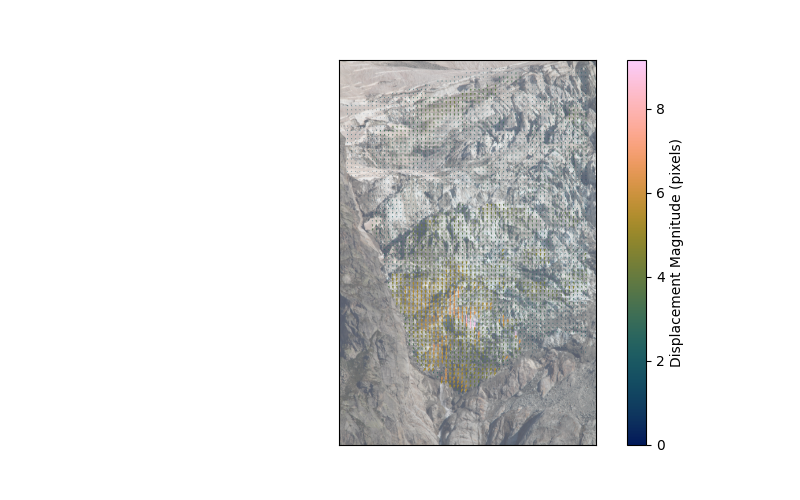

In [65]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_dic_vectors(
    x=df["x"].to_numpy(),
    y=df["y"].to_numpy(),
    u=df["u"].to_numpy(),
    v=df["v"].to_numpy(),
    magnitudes=df["V"].to_numpy(),
    background_image=img,
    cmap_name="batlow",
    # vmin=0.1,
    # vmax=10,
    fig=fig,
    ax=ax,
)
fig.savefig(output_dir / f"{base_name}_dic.png", dpi=300, bbox_inches="tight")


GMM


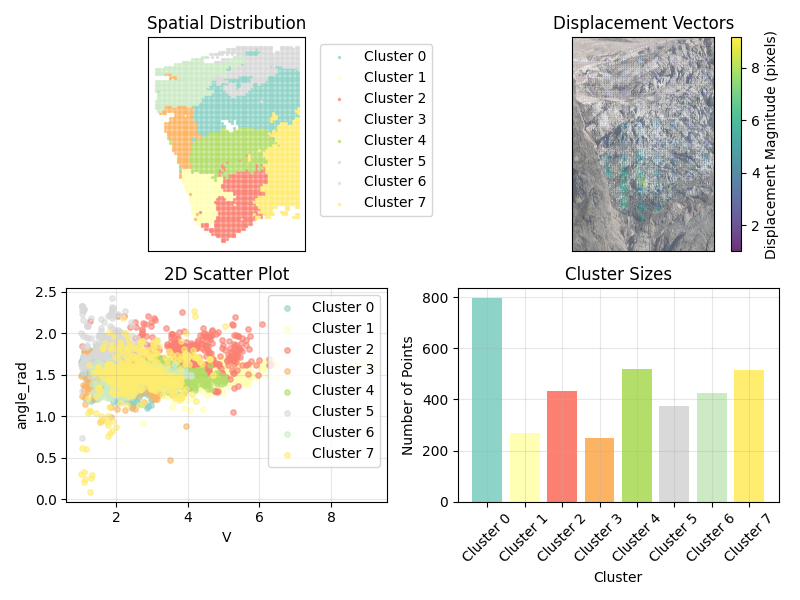

In [66]:
# --- Run GMM clustering and plot ---
variables_names = ["x", "y", "V", "angle_rad"]
n_components = 8
max_iter = 100
random_state = 42
covariance_type = "full"

df_features = preproc_features(df)
features = df_features[variables_names].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

gmm = GaussianMixture(
    n_components=n_components,
    covariance_type=covariance_type,
    max_iter=max_iter,
    random_state=random_state,
)
gmm.fit(features_scaled)
labels = gmm.predict(features_scaled)
df_features["cluster"] = labels

fig, ax, stats_df = plot_gmm_clusters(
    df_features,
    labels,
    var_names=["V", "angle_rad"],
    img=img,
    figsize=(8, 6),
)
fig.savefig(output_dir / f"{base_name}_clusters.png", dpi=300, bbox_inches="tight")

# Save the GMM model
joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
joblib.dump(
    gmm,
    output_dir / f"{base_name}_model_comp{n_components}_cov{covariance_type}.joblib",
)

# Save the features DataFrame with labels
df_features.to_csv(output_dir / f"{base_name}_features_with_labels.csv", index=False)

/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/francesco/ppcx/ppcx-domains/src/clustering.py:341: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, 6))


<Axes: title={'center': 'GMM Negative log-likelihood: V vs angle_rad'}, xlabel='V (scaled)', ylabel='angle_rad (scaled)'>

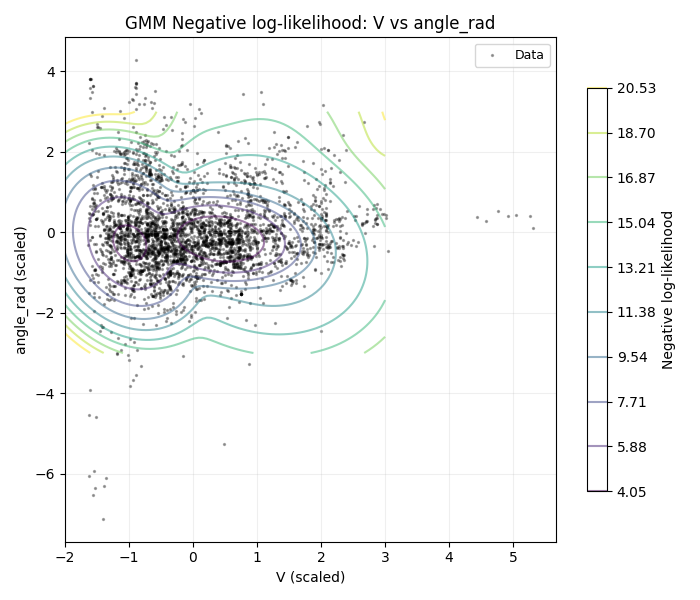

In [67]:
plot_gmm_log_likelihood_contours(
    df_features, gmm, scaler, variables_names, pair=("V", "angle_rad")
)

Variational Bayesian Gaussian Mixture


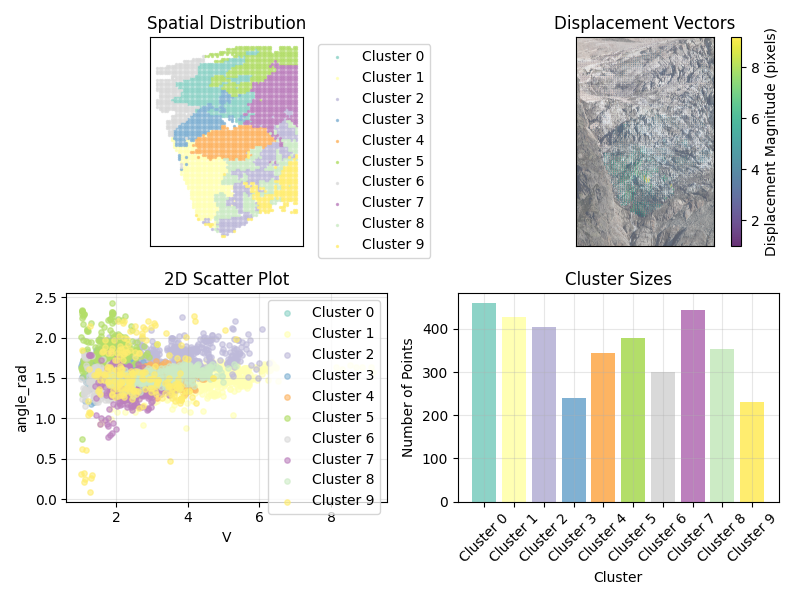

(<Figure size 800x600 with 5 Axes>,
 array([[<Axes: title={'center': 'Spatial Distribution'}>,
         <Axes: title={'center': 'Displacement Vectors'}>],
        [<Axes: title={'center': '2D Scatter Plot'}, xlabel='V', ylabel='angle_rad'>,
         <Axes: title={'center': 'Cluster Sizes'}, xlabel='Cluster', ylabel='Number of Points'>]],
       dtype=object),
      Cluster  Count  Mean_Magnitude  Mean_Direction  Std_Magnitude
 0  Cluster 0    459        2.761748       86.687953       0.591917
 1  Cluster 1    428        4.709126       84.072432       1.119908
 2  Cluster 2    405        3.746470       99.664007       0.952785
 3  Cluster 3    239        1.899989       92.203082       0.409276
 4  Cluster 4    345        3.466011       86.621276       0.408742
 5  Cluster 5    379        1.793725      103.054843       0.391608
 6  Cluster 6    300        1.682483       81.967391       0.332838
 7  Cluster 7    444        2.397462       80.219250       0.406924
 8  Cluster 8    354      

In [68]:
from sklearn.mixture import BayesianGaussianMixture

df_features = preproc_features(df)

variables_names = ["x", "y", "V", "angle_rad"]
n_components = 6
max_iter = 100
random_state = 42
covariance_type = "full"

features = df_features[variables_names].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

gmm = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior=1e-3,
    covariance_type=covariance_type,
    max_iter=max_iter,
    random_state=random_state,
)
gmm.fit(features_scaled)
labels = gmm.predict(features_scaled)

plot_gmm_clusters(
    df_features,
    labels,
    var_names=["V", "angle_rad"],
    img=img,
    figsize=(8, 6),
)

In [69]:
# # --- Post-process clustering ---
# min_cluster_size = 30
# smoothing_window_size = 10
# labels_clean = remove_small_clusters(labels, min_size=min_cluster_size)
# labels_smooth = spatial_smooth_labels(
#     df_features, labels_clean, window_size=smoothing_window_size
# )
# labels_smooth = merge_similar_clusters(df_features, labels_smooth, threshold=10)

# # Plot results after cleaning and smoothing
# plot_gmm_clusters(
#     df_features,
#     labels_smooth,
#     var_names=["V", "angle_rad"],
#     img=img,
#     figsize=(8, 6),
# )
